#### Utility code to convert from CSV to feather for faster load times

In [1]:
import pandas as pd
import feather

#################### READ CSV #########################
# df = pd.read_csv('./all/train.csv', parse_dates=['pickup_datetime'])
################## WRITE FEATHER ######################
# df.to_feather('./all/train.feather')
################## READ FEATHER #######################
df = pd.read_feather('./all/train.feather')

# Describe the original dataset

In [2]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.542386e+07,5.542386e+07,5.542386e+07,5.542348e+07,5.542348e+07,5.542386e+07
mean,1.134505e+01,-7.250968e+01,3.991979e+01,-7.251121e+01,3.992068e+01,1.685380e+00
std,2.071083e+01,1.284888e+01,9.642353e+00,1.278220e+01,9.633346e+00,1.327664e+00
min,-3.000000e+02,-3.442060e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396367e+01,4.076810e+01,2.000000e+00
max,9.396336e+04,3.457626e+03,3.408790e+03,3.457622e+03,3.537133e+03,2.080000e+02


### Instantly recognizable outliers:
* **passenger_count**
    * Passenger counts of 0
    * Infeasible passenger counts (e.g. 200). Taxis can legally hold up to 4-6 passengers (http://www.nyc.gov/html/tlc/html/faq/faq_pass.shtml)
* **fare_amount**
    * Negative fare amounts
    * Extremely high fare amounts (thousands of dollars)
* **coordinates**
    * Invalid coordinates (out of defined range)
    * Coordinates outside of NYC

***
# Data cleaning functions:
#### Check for invalid coordinates (outside of NYC range), determined with https://www.mapdevelopers.com/geocode_bounding_box.php

In [6]:
def clean_coordinates(df):
    df.query('~(pickup_latitude < 40.477399 or pickup_latitude > 40.917577) &\
              ~(dropoff_latitude < 40.477399 or dropoff_latitude > 40.917577) &\
              ~(pickup_longitude < -74.259090 or pickup_longitude > -73.700272) &\
              ~(dropoff_longitude < -74.259090 or dropoff_longitude > -73.700272)', inplace=True)

#### Remove invalid passenger counts, fares. Upper bound to both. Also drop missing values and key column.

In [7]:
def clean_pfdk(df):
    df.drop(columns=['key'], inplace=True)
    df.dropna(inplace=True)
    df.query('passenger_count > 0 &\
              passenger_count <= 6 &\
              fare_amount > 0 &\
              fare_amount <= 100 ', inplace=True)

***
# Feature Engineering functions:
***
#### Calculate Euclidean Distance (and drop rows with distance = 0 if training). 

In [8]:
def euclidean_distance(x1, y1, x2, y2):
    return ((x2-x1)**2 + (y2-y1)**2)**0.5

def add_euclidean_distance(df, training=True):
    df['euclidean_distance'] = euclidean_distance(df['pickup_latitude'], 
                                                  df['pickup_longitude'], 
                                                  df['dropoff_latitude'], 
                                                  df['dropoff_longitude'])
    if training:
        df.query('euclidean_distance > 0', inplace=True)
        df.reset_index(drop=True, inplace=True)

#### Calculate Manhattan Distance (and drop rows with distance = 0 if training). 

In [9]:
def manhattan_distance(x1, y1, x2, y2):
    return abs(x2-x1) + abs(y2-y1)

def add_manhattan_distance(df, training=True):
    df['manhattan_distance'] = manhattan_distance(df['pickup_latitude'], 
                                                  df['pickup_longitude'], 
                                                  df['dropoff_latitude'], 
                                                  df['dropoff_longitude'])
    if training:
        df.query('manhattan_distance > 0', inplace=True)
        df.reset_index(drop=True, inplace=True)

#### Because of fixed fares, also calculate distance (euclidean) to/from airports.
* Coordinates determined with a Google Maps query

In [10]:
def add_jfk(df):
    df['go_jfk'] = euclidean_distance(df['dropoff_latitude'], df['dropoff_longitude'], 40.6413, -73.7781)
    df['leave_jfk'] = euclidean_distance(df['pickup_latitude'], df['pickup_longitude'], 40.6413, -73.7781)
def add_lga(df):
    df['go_lga'] = euclidean_distance(df['dropoff_latitude'], df['dropoff_longitude'], 40.7769, -73.8740)
    df['leave_lga'] = euclidean_distance(df['pickup_latitude'], df['pickup_longitude'], 40.7769, -73.8740)
def add_ewr(df):
    df['go_ewr'] = euclidean_distance(df['dropoff_latitude'], df['dropoff_longitude'], 40.6895, -74.1745)
    df['leave_ewr'] = euclidean_distance(df['pickup_latitude'], df['pickup_longitude'], 40.6895, -74.1745)

#### Extract Time Values

In [11]:
def add_times(df):
    df['year']  = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day']   = df['pickup_datetime'].dt.day
    df['hour']  = df['pickup_datetime'].dt.hour + (df['pickup_datetime'].dt.minute/60)
    df.drop(columns=['pickup_datetime'], inplace=True)

#### External data: Monthly Gas Prices acquired from https://data.bls.gov/timeseries/APU000074714

In [12]:
def add_gas_prices(df):
    gas_df = pd.read_csv('./all/gas_prices.csv')
    gas_dict = {}
    for row in gas_df.itertuples():
        year = row[1]
        for i in range(2, len(row)):
            gas_dict['{0}-{1}'.format(year, i-1)] = row[i]
    df['year-month']  = df['year'].astype(str) + '-' + df['month'].astype(str)
    df['gas'] = df['year-month'].map(gas_dict)
    df.drop(columns=['year-month'], inplace=True)

#### Preprocess pipeline function

In [13]:
def preprocess(df, training=True):
    if training:
        clean_pfdk(df)
        clean_coordinates(df)
        df.reset_index(drop=True, inplace=True)
    add_euclidean_distance(df, training)
    add_manhattan_distance(df, training)
    add_jfk(df)
    add_lga(df)
    add_ewr(df)
    add_times(df)
    add_gas_prices(df)

#### Utility code to preprocess training data and save/load as feather

In [21]:
import pandas as pd
import feather

############## PREPROCESS TRAINING DATA $##############
# preprocess(df, training=True)
############## WRITE PREPROCESSED FEATHER #############
# df.to_feather('./all/preprocessed_train.feather')
######### READ PREPROCESSED FEATHER ###################
df = pd.read_feather('./all/preprocessed_train.feather')

***
# Visualization:
> Correlations measured on entire dataset. Plotting done with subset of points.
#### Correlation Heatmap

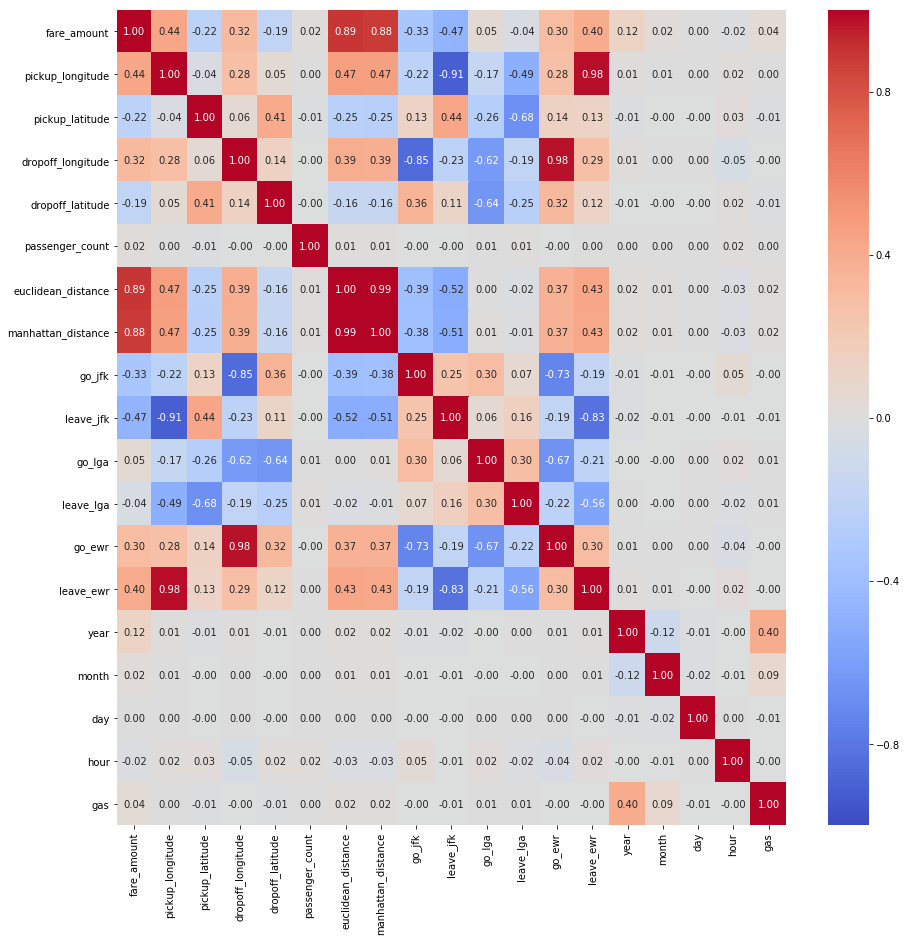

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

corr_matrix = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, vmin=-1, vmax=1, fmt='.2f')
plt.show()

Observations:
* Euclidean distance has the highest correlation with fare amount
* Distance to/from an airport is significant due to flat fares (detailed in link below).
    * http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml
* Manhattan distance is almost perfectly correlated with euclidean
* Latidude is negatively correlated with fare
* Longitude is positively correlated with fare
* Year has a small positive correlation (0.12) with fare. Makes sense since costs slowly rise with inflation.

#### Scatter plot (Euclidean Distance, Fare Amount)

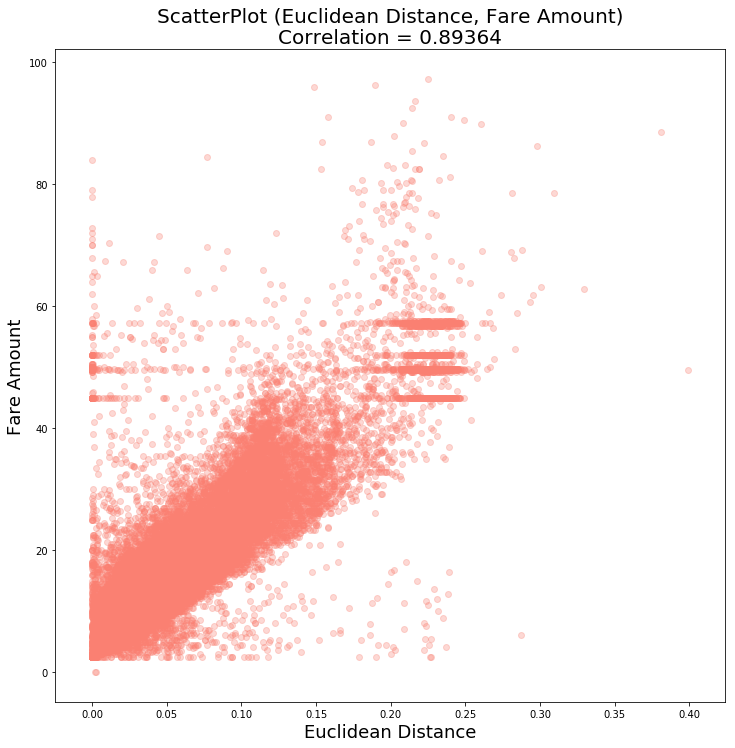

In [13]:
df_plot = df.head(100000)

corr = corr_matrix['euclidean_distance']['fare_amount']
plt.figure(figsize=(12,12))
plt.scatter(df_plot['euclidean_distance'], df_plot['fare_amount'], color='salmon', alpha=0.3)
plt.title('ScatterPlot (Euclidean Distance, Fare Amount)\nCorrelation = {0:.5f}'.format(corr), fontsize=20)
plt.xlabel('Euclidean Distance', fontsize=18)
plt.ylabel('Fare Amount', fontsize=18)
plt.show()

Observations:
* Very strong correlation (0.87)
* There are three groups of fixed fares over any distance. This makes sense because there are usually fixed fares to JFK, Newark, and LaGuardia airports. 

#### ScatterPlot (Time of Day, Distance Traveled)

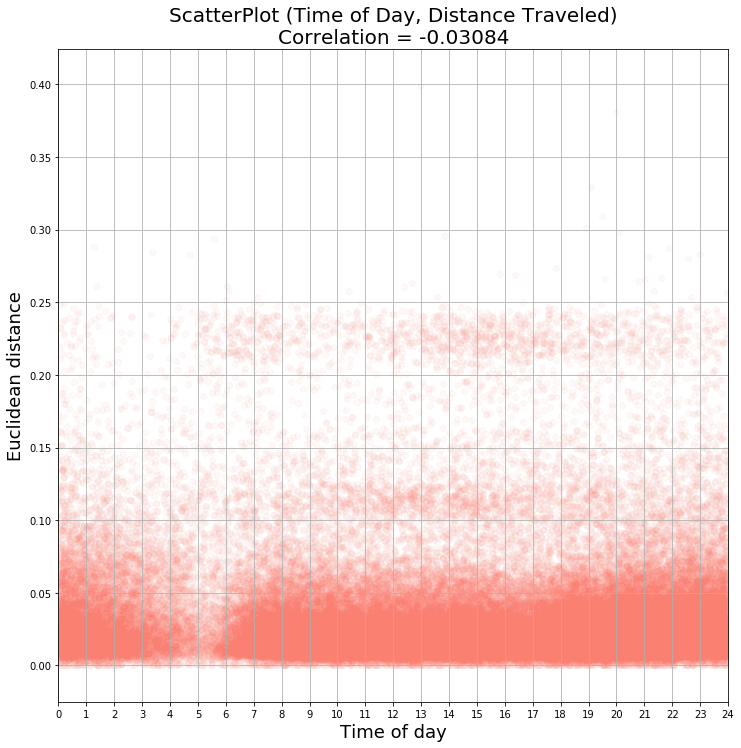

In [14]:
corr = corr_matrix['hour']['euclidean_distance']
plt.figure(figsize=(12,12))
plt.scatter(df_plot['hour'], df_plot['euclidean_distance'], color='salmon', alpha=0.05)
plt.title('ScatterPlot (Time of Day, Distance Traveled)\nCorrelation = {0:.5f}'.format(corr), fontsize=20)
plt.xlabel('Time of day', fontsize=18)
plt.ylabel('Euclidean distance', fontsize=18)
plt.xlim(0,24)
plt.xticks(range(0,25))
plt.grid(True)
plt.show()

Observations:
* Seems to be very low/negligible correlation (-0.03)
* Naturally, less people travel in the early morning

#### ScatterPlot (Time of Day, Fare Amount)

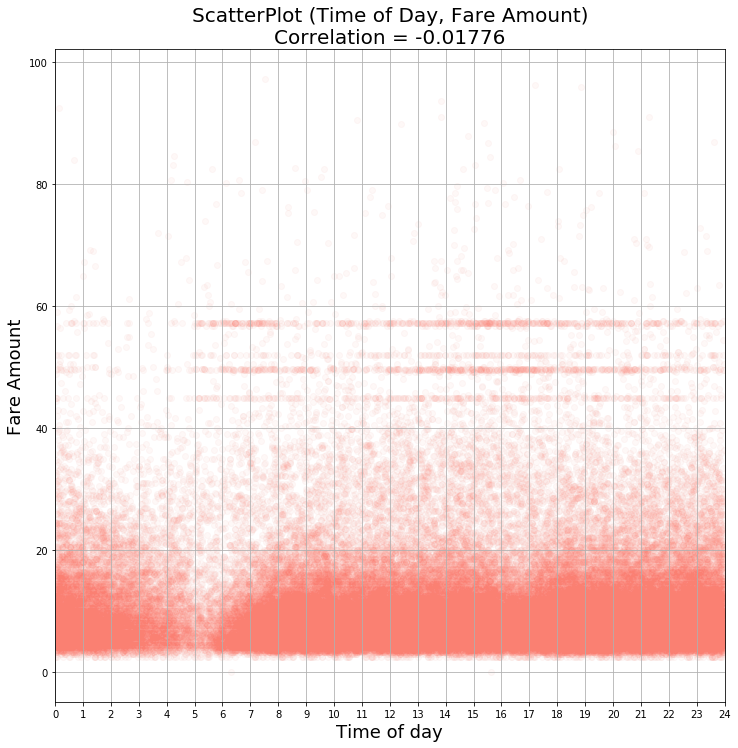

In [15]:
corr = corr_matrix['hour']['fare_amount']
plt.figure(figsize=(12,12))
plt.scatter(df_plot['hour'], df_plot['fare_amount'], color='salmon', alpha=0.05)
plt.title('ScatterPlot (Time of Day, Fare Amount)\nCorrelation = {0:.5f}'.format(corr), fontsize=20)
plt.xlabel('Time of day', fontsize=18)
plt.ylabel('Fare Amount', fontsize=18)
plt.xlim(0,24)
plt.xticks(range(0,25))
plt.grid(True)
plt.show()

Observations:
* Correlation also very weak (-0.018)
* Three groups of fixed fares also visible here

#### Fares by Destination

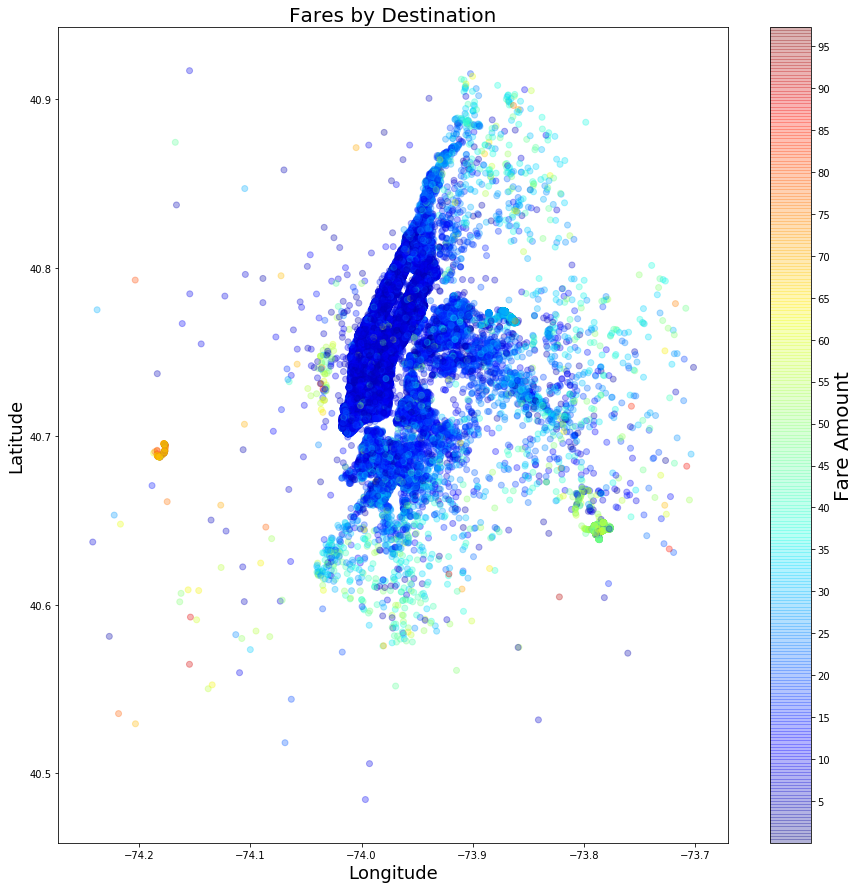

In [16]:
plt.figure(figsize=(15,15))
plt.scatter(df_plot['dropoff_longitude'], df_plot['dropoff_latitude'], 
            c=df_plot['fare_amount'], cmap=plt.get_cmap('jet'), alpha=0.3)
colorbar = plt.colorbar()
colorbar.set_ticks(range(5,100,5))
colorbar.ax.set_ylabel('Fare Amount', fontsize=20)
plt.title('Fares by Destination', fontsize = 20)
plt.xlabel('Longitude', fontsize=18)
plt.ylabel('Latitude', fontsize=18)
plt.show()

Obervations:
* JFK and Newark immediately stand out as the most expensive destinations.
* Travelling across the Hudson river is expensive (explained by tolls).
* Long distance trips from Manhattan are much less frequent, but understandably more expensive.

***   
# Train/Test split wrapper function
Can specify number of rows to train on and test subset size.

In [15]:
# SPLIT TRAIN/TEST DATA
from sklearn.model_selection import train_test_split

def get_tt_split(df, test_size=0.2):
    y = df['fare_amount']
    X = df.drop(columns=['fare_amount', 'manhattan_distance'])
    return train_test_split(X, y, test_size=test_size, random_state=3)

***
# Model: Linear Regression

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def train_lr(df):
    X_train, X_test, y_train, y_test = get_tt_split(df, test_size=0.005)
    
    model = LinearRegression()
    print('Training model: {0}...'.format('lr'))
    model.fit(X_train, y_train)

    test_predictions = model.predict(X_test)
    print('Mean Squared Error (Training):', mean_squared_error(y_test, test_predictions))
    print('\nCOEFFICIENTS:')
    for i in list(zip(X_test.columns, model.coef_)):
        print('{0}: {1}'.format(i[0], i[1]))
    print('==============================')
    print('\nINTERCEPT:', model.intercept_)
    
    return model

#### Training Results:

In [19]:
lr_model = train_lr(df)

Training model: lr...
Mean Squared Error (Training): 15.592532925649525

COEFFICIENTS:
pickup_longitude: 92.93060911256946
pickup_latitude: -12.300038214688389
dropoff_longitude: -8.922808871731053
dropoff_latitude: -31.591239194401766
passenger_count: 0.034289645146766315
euclidean_distance: 214.6225844331629
go_jfk: 29.19578518551523
leave_jfk: 52.29634495616551
go_lga: 2.084051558818984
leave_lga: -4.146116986297293
go_ewr: 24.561993785837007
leave_ewr: -41.81430892747757
year: 0.5539309803191294
month: 0.0774801236646523
day: 0.0011416108996493899
hour: 0.011892105083730564
gas: -0.36482813604822895

INTERCEPT: 6878.398606643703


Observations:
* Most important feature: euclidean distance
* Scaling has no effect on performance

In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def train_rfr():
    X_train, X_test, y_train, y_test = get_tt_split(df, test_size=0.005)
    
    model = RandomForestRegressor()
    print('Training model: {0}...'.format('rfr'))
    model.fit(X_train, y_train)

    test_predictions = model.predict(X_test)
    print('Mean Squared Error (Training):', mean_squared_error(y_test, test_predictions))
    return model

In [24]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

def train_gbr():
    X_train, X_test, y_train, y_test = get_tt_split(df, test_size=0.005)
    
    model = GradientBoostingRegressor(learning_rate=0.2)
    print('Training model: {0}...'.format('gbr'))
    model.fit(X_train, y_train)

    test_predictions = model.predict(X_test)
    print('Mean Squared Error (Training):', mean_squared_error(y_test, test_predictions))
    return model

In [51]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

def train_mlp():
    X_train, X_test, y_train, y_test = get_tt_split(df.head(1000000), test_size=0.005)
    
    model = MLPRegressor()
    print('Training model: {0}...'.format('mlp'))
    model.fit(X_train, y_train)

    test_predictions = model.predict(X_test)
    print('Mean Squared Error (Training):', mean_squared_error(y_test, test_predictions))
    return model

# Specify model:

In [39]:
selected_model = 'lr'

# Preprocess/fit model to real test data:

In [ ]:
real_df = pd.read_csv('./all/test.csv', parse_dates=['pickup_datetime'])
preprocess(real_df, training=False)

real_X = real_df.drop(columns=['key', 'manhattan_distance'])

if selected_model == 'lr':
    model = train_lr(df)
elif selected_model == 'rfr':
    model = train_rfr()
elif selected_model == 'gbr':
    model = train_gbr()
elif selected_model == 'mlp':
    model = train_mlp()

predictions = model.predict(real_X)

data = list(zip(real_df['key'], predictions))

submission = pd.DataFrame(data, columns=['key', 'fare_amount'])
submission.set_index('key', inplace=True)
submission.to_csv('submission.csv')
print('----------------------------')
print('Predictions written to submissions.csv')

## Best Kaggle Scores by model (RMSE):
* Linear Regression: 5.64822
* Random Forest Regressor: 3.61372
* Gradient Boosting Regressor: 3.59701
* Multilayer Perceptron Regressor: 4.70227